In [ ]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import manifold
import numpy as np
from sentence_transformers import SentenceTransformer
import pyrootutils
import hydra

pyrootutils.set_root(os.path.abspath(".."), pythonpath=True)

from src.utils.data import load_news, load_users
from src.utils.hydra import RunCollection
from src.evaluation.metrics import gs_score, ild
from src.utils.notebook import get_figsize, save_to_latex, plot_latex_style


In [93]:
with hydra.initialize(version_base=None, config_path="../conf"):
    cfg = hydra.compose(config_name="notebook")

MIN_HISTORY_LENGTH = 3

In [16]:
runs = RunCollection.from_path("../outputs")
runs = runs.filter_by_job("train_embeddings")
run = runs.one()
run.show_config()

seed: 515
epochs: 10
embedding_dim: 100
batch_size: 128
learning_rate: 0.001
n_negative_samples: 4
data:
  seed: 468
  num_users: 200000
  source: large
  target: ${data.num_users}_${data.seed}
  mind_variant: ${data.target}



In [4]:
metrics = pd.read_csv(run.get_file_path("metrics.csv"))
metrics

,P@1,P@5,MRR,FMI,Silhouette,Train loss,epoch
0,0.000,0.000,0.073282,0.287594,0.297637,0.903918,0
1,0.000,0.500,0.172520,0.284227,0.413630,0.438126,1
2,0.000,0.500,0.209265,0.283156,0.444662,0.414427,2
3,0.125,0.750,0.339576,0.278538,0.455532,0.397396,3
4,0.000,0.625,0.219583,0.280536,0.457033,0.385194,4
5,0.000,0.500,0.203013,0.275973,0.463143,0.374783,5
6,0.000,0.500,0.196939,0.274677,0.446814,0.365187,6
7,0.000,0.500,0.193173,0.271252,0.438696,0.356269,7
8,0.000,0.500,0.173803,0.266217,0.423577,0.347888,8
9,0.000,0.375,0.167285,0.266011,0.419336,0.340088,9


In [5]:
best_epoch = int(metrics.iloc[metrics["P@5"].idxmax()]["epoch"])
print(f"Using topic embeddings from epoch {best_epoch}")
topic_embeddings_path = run.get_file_path(f"topic_embeddings_{best_epoch}.feather")
topic_embeddings = pd.read_feather(topic_embeddings_path)
topic_embeddings

Using topic embeddings from epoch 3


,subcategory,embedding
0,ads-latingrammys,"[-0.5279844, 1.2566609, 0.09642819, -0.2321693..."
1,ads-lung-health,"[0.07290848, -0.108872466, -0.116296835, 0.058..."
2,advice,"[-0.07572569, -0.05586439, -0.103811264, -0.10..."
3,animals,"[0.114049695, -0.09510901, -0.15006417, -0.116..."
4,autosbuying,"[0.012851537, 0.12294536, -0.030278068, 0.0524..."
...,...,...
249,weightloss,"[-0.075820275, -1.4854307e-05, 0.16013281, -0...."
250,wellness,"[-0.018470695, -0.04485918, 0.08147979, -0.051..."
251,wines,"[-1.0180085, -0.6784834, -0.5070956, -0.352719..."
252,wonder,"[0.11814448, -0.012971732, -0.12646337, -0.029..."


In [6]:
mind_variant = run.config.data.mind_variant
news = load_news(mind_variant, columns=["category", "subcategory", "title"], data_dir=cfg.data_dir)
news = news.drop(columns="split")
news

,category,subcategory,title
id,,,
N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an..."
N23144,health,weightloss,50 Worst Habits For Belly Fat
N86255,health,medical,Dispose of unwanted prescription drugs during ...
N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...
N75236,health,voices,I Was An NBA Wife. Here's How It Affected My M...
...,...,...,...
N8607,news,newsgoodnews,"Monroe boy, 11, called 'hero' for calling 911,..."
N130348,autos,autosnews,Virgin Trains construction to close downtown M...
N41349,news,newspolitics,Analysis: Trump's core impeachment defense suf...


In [7]:
categories_in_news = set(news["subcategory"])
categories_in_embeddings = set(topic_embeddings["subcategory"])
missing_categories = categories_in_news.difference(categories_in_embeddings)
missing_categories = pd.DataFrame(missing_categories, columns=["subcategory"])
print("Missing categories:")
news\
    .merge(missing_categories, on="subcategory")\
    .groupby("subcategory")\
    .count()\
    .reset_index()\
    .rename(columns={"category": "n_articles"})

Missing categories:


,subcategory,n_articles,title
0,autoslosangeles,1,1
1,autosmidsize,1,1
2,basketball,1,1
3,cardio,1,1
4,causes-poverty,1,1
5,entertainmentmusic,1,1
6,entertainmenttv,1,1
7,finance-startinvesting,1,1
8,foodanddrink,1,1
9,halloween,1,1


In [8]:
news_with_embeddings = news.reset_index().merge(topic_embeddings, on="subcategory")
n_excluded_news = len(news) - len(news_with_embeddings)
news = news_with_embeddings
news = news.rename(columns={'embedding': 'topic_embedding'})
news = news.set_index("id")
news

,category,subcategory,title,topic_embedding
id,,,,
N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N81543,lifestyle,lifestyleroyals,Kate Middleton's Best Hairstyles Through the Y...,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N71593,lifestyle,lifestyleroyals,Every outfit Duchess Kate has worn in 2019,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N33576,lifestyle,lifestyleroyals,25 Photos of the Royal Family at Balmoral Cast...,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
N115791,lifestyle,lifestyleroyals,Prince George's Royal Life in Photos,"[-0.05900184, -0.11635385, 0.0978779, -0.09877..."
...,...,...,...,...
N53304,lifestyle,relationships,Want to Plan the Best Christmas Proposal Ever?...,"[1.4300101, -0.51480174, 1.3971273, 0.66752815..."
N99911,autos,autosconvertibles,2020 Chevrolet Corvette C8 Convertible Price S...,"[1.8388319, 1.0420269, 0.40700355, 0.23218808,..."
N61853,sports,olympics-videos,NBA head to travel to China amid flap over pro...,"[-0.3969354, -0.6827047, -1.0807043, -0.829718..."


In [9]:
pretrained_model_name = "all-distilroberta-v1"
model = SentenceTransformer(pretrained_model_name)
title_embeddings = model.encode(news["title"], show_progress_bar=True, convert_to_numpy=True)
news["title_embedding"] = list(title_embeddings)

Batches:   0%|          | 0/2449 [00:00<?, ?it/s]

In [249]:
embeddings = np.stack(news["title_embedding"].values)
seed = 1234
tsne = manifold.TSNE(n_components=2, random_state=seed)
tsne_embeddings = tsne.fit_transform(embeddings)
title_embeddings = news[["category", "title_embedding"]]
title_embeddings["tsne_x"] = tsne_embeddings[:,0]
title_embeddings["tsne_y"] = tsne_embeddings[:,1]

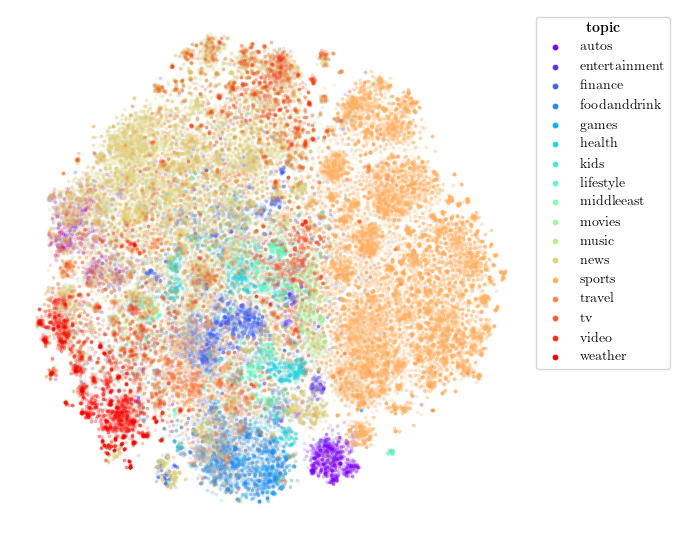

In [ ]:
with plot_latex_style():
    fig, ax = plt.subplots(figsize=get_figsize(fraction=1, aspect_ratio=1))
    colors = cm.rainbow(np.linspace(0, 1, len(title_embeddings.groupby("category"))))
    for color, (label, df) in zip(colors, title_embeddings.groupby("category")):
        df.plot(
            "tsne_x",
            "tsne_y",
            kind="scatter",
            ax=ax,
            label=label,
            color=tuple(color),
            s=3,
            alpha=0.1
        )

    legend = plt.legend(title=r"\textbf{topic}", bbox_to_anchor=(1, 1))
    for handle in legend.legend_handles:
        handle.set_alpha(1)
        handle.set_sizes([10])
    plt.axis("off")
    plt.savefig(os.path.join(cfg.images_dir, "title_embeddings_tsne_rasterized.png"), dpi=300, bbox_inches="tight")
    plt.show()


In [27]:
users = load_users(mind_variant, data_dir=DATA_DIR)
users = users.drop(columns="split")
users

,history
user,
U114779,"[N14678, N35786, N91030, N76664, N40228, N4786..."
U386485,"[N112642, N84454, N22660]"
U287749,"[N10263, N65119, N81899, N4289, N49685, N46994..."
U714431,"[N25197, N107441, N72135, N93987, N112751, N97..."
U78193,"[N62519, N100420, N3113, N9818, N62519, N98108..."
...,...
U712701,[N30049]
U720522,"[N37303, N42763, N49889, N74723, N16534]"
U727781,"[N87105, N92474, N106931, N25561, N69442, N108..."


In [28]:
reading_history = users.explode("history")
reading_history = reading_history.merge(news, left_on="history", right_index=True)
user_reads = reading_history.groupby("user")

embeddings = ["topic", "title"]
scoring_methods = {
    "gs": gs_score,
    "ild": ild,
}

for embedding in embeddings:
    for scoring_method, scoring_fn in scoring_methods.items():
        key = f"{embedding}_{scoring_method}"
        users[key] = user_reads.apply(lambda x: scoring_fn(list(x[f"{embedding}_embedding"].values)) if len(x) > 1 else None)

users

,history,topic_gs,topic_ild,title_gs,title_ild
user,,,,,
U114779,"[N14678, N35786, N91030, N76664, N40228, N4786...",0.395319,0.657392,0.616564,0.888518
U386485,"[N112642, N84454, N22660]",0.256545,0.655446,0.374878,0.913834
U287749,"[N10263, N65119, N81899, N4289, N49685, N46994...",0.425943,0.706591,0.644126,0.931578
U714431,"[N25197, N107441, N72135, N93987, N112751, N97...",0.481795,0.758805,0.679772,0.934848
U78193,"[N62519, N100420, N3113, N9818, N62519, N98108...",0.458791,0.732880,0.678624,0.931207
...,...,...,...,...,...
U712701,[N30049],NaN,NaN,NaN,NaN
U720522,"[N37303, N42763, N49889, N74723, N16534]",0.305575,0.634237,0.546249,0.992638
U727781,"[N87105, N92474, N106931, N25561, N69442, N108...",0.410243,0.692273,0.660113,0.958183


In [29]:
users["history_length"] = users["history"].apply(len)
included_users = users[users["history_length"] >= MIN_HISTORY_LENGTH].copy()

included_users["activity_percentile"] = pd.qcut(
    included_users.history_length, np.linspace(0, 1, 11), labels=np.arange(1, 11)/10
)

activity_percentiles = included_users.groupby("activity_percentile")

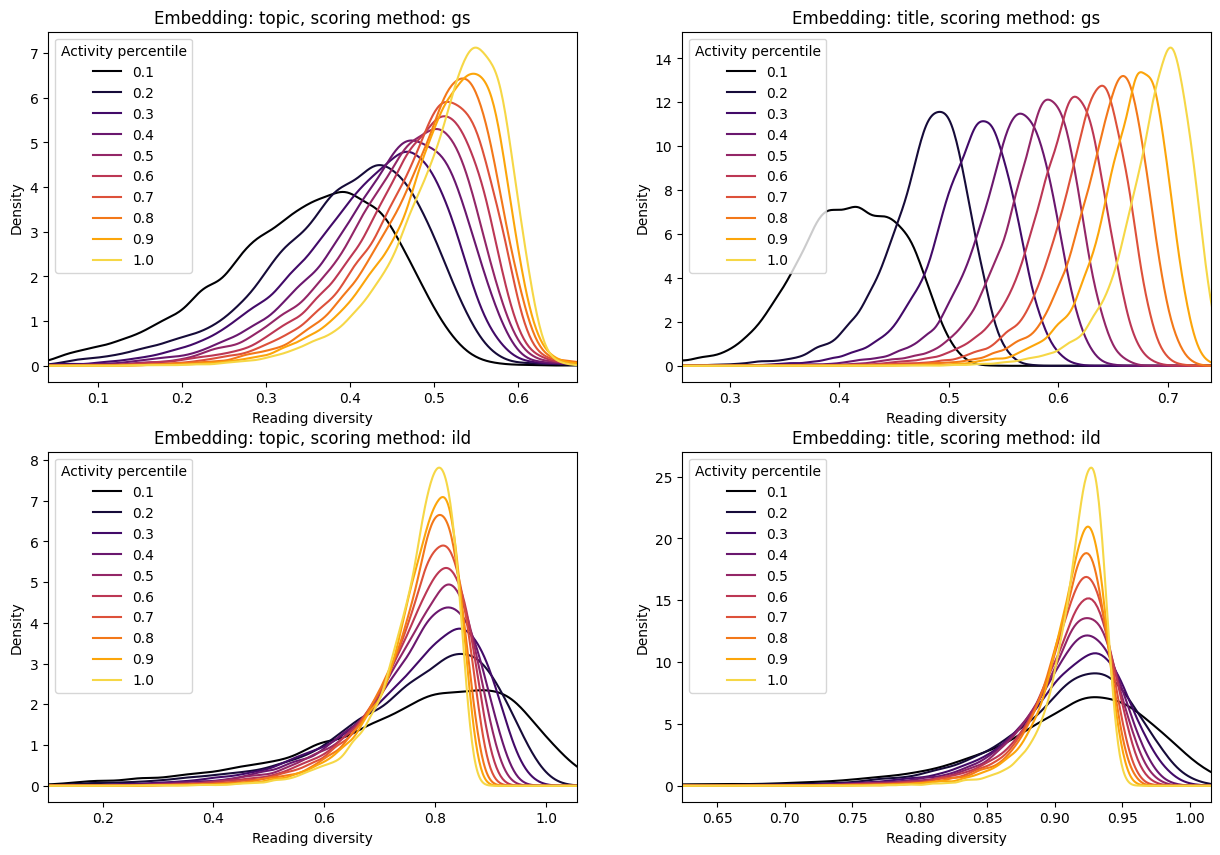

In [31]:
cutoff = 0.002
colors = cm.inferno(np.linspace(0, 1, 11))[:10]

fig, axs = plt.subplots(len(scoring_methods), len(embeddings), figsize=(15, 10))
for col, embedding in enumerate(embeddings):
    for row, scoring_method in enumerate(scoring_methods):
        key = f"{embedding}_{scoring_method}"
        ax = axs[row, col]
        ax.set_xlim((included_users[key].quantile(cutoff), included_users[key].quantile(1-cutoff)))
        ax.set_xlabel("Reading diversity")
        ax.set_title(f"Embedding: {embedding}, scoring method: {scoring_method}")
        for color, (label, df) in zip(colors, activity_percentiles):
            df[key].plot(kind="kde", ax=ax, label=label, color=color)
        legend = ax.legend()
        legend.set_title("Activity percentile")


In [ ]:
with plot_latex_style():
for embedding in embeddings:
    for scoring_method in scoring_methods:
        fig, ax = plt.subplots(figsize=get_figsize(fraction=0.48))
        key = f"{embedding}_{scoring_method}"
        ax.set_xlim((included_users[key].quantile(cutoff), included_users[key].quantile(1-cutoff)))
        for color, (label, df) in zip(colors, activity_percentiles):
            df[key].plot(kind="kde", ax=ax, label=label, color=color)
        plt.savefig(os.path.join(cfg.images_dir, f"density_{key}.pdf"), format="pdf", bbox_inches="tight")
        plt.clf()


In [166]:
metric_columns = [f"{embedding}_{scoring_method}" for embedding in embeddings for scoring_method in scoring_methods]

corr_to_history = included_users[["history_length"] + metric_columns]\
    .corr()\
    .drop(index="history_length")\
    [["history_length"]]

metric_stats = included_users[metric_columns].agg(["mean", "std", "median", "kurtosis"]).T
metric_stats["correlation"] = corr_to_history
metric_stats.index = metric_stats.index.map(lambda x: (x.split("_")[0].capitalize(), x.split("_")[1].upper())).set_names(["Embeddings", "Metric"])
metric_stats = metric_stats.swaplevel().sort_index(level=0).reindex(["Topic", "Title"], level=1)
metric_stats

mean       std    median   kurtosis  correlation
Metric Embeddings                                                      
GS     Topic       0.449390  0.103005  0.467594   1.119038     0.333955
       Title       0.570433  0.096896  0.586360  -0.051664     0.587389
ILD    Topic       0.760713  0.123447  0.784839   5.026785     0.022645
       Title       0.908696  0.045992  0.916861  28.082393     0.059380

In [197]:
def format_column_header(s):
    if len(s) < 15:
        return r'\textbf{' + s.capitalize() + '}'
    else:
        return r'\parbox{3.2cm}{\textbf{' + s.capitalize() + '}}'

save_to_latex(
    cfg.tables_dir,
    "diversity_metric_stats",
    metric_stats\
        .reset_index()\
        .rename(columns={
            "std": "Std. dev.",
            "correlation": "Correlation to \# of news read"
        })\
        .style\
        .format(precision=3),
    caption="Statistics of different methods to measure diversity.",
    format_column_header=format_column_header
)

In [202]:
nondiverse_users = included_users[included_users["topic_gs"] < included_users["topic_gs"].quantile(0.1)]
diverse_users = included_users[included_users["topic_gs"] > included_users["topic_gs"].quantile(0.9)]


In [222]:
def get_history(user):
    history = news.loc[user.history[0]][["category", "subcategory", "title"]]
    return history

In [223]:
nondiverse_user = nondiverse_users.sample(1)
get_history(nondiverse_user)

,category,subcategory,title
id,,,
N35269,tv,tv-celebrity,Lori Loughlin's Daughters No Longer Enrolled a...
N14611,news,newspolitics,CNN Poll: Biden's lead in Democratic primary h...
N27352,movies,movies-celebrity,"Emily Ratajkowski Is Being Sued for $150,000 O..."
N61481,movies,movies-celebrity,"Ben Affleck is dating again, using Raya app"
N129083,entertainment,entertainment-celebrity,Kylie Jenner and her bestie get surgery togeth...
N128648,entertainment,celebrity,"Lady Gaga, Jim Carrey, Christina Hendricks and..."
N13872,entertainment,entertainment-celebrity,When Costars Clash: 13 Onscreen Pairs Who Were...
N6668,tv,tvnews,Emilia Clarke Reacts to the 'Game of Thrones' ...
N98095,news,newscrime,5 charged in alcohol poisoning death of UC Irv...


In [238]:
save_to_latex(
    cfg.tables_dir,
    "history_nondiverse_user",
    get_history(nondiverse_user)\
        .reset_index(drop=True)\
        .rename(columns={"category": "topic", "subcategory": "subtopic"})\
        .style\
        .format(escape="latex"),
    caption="User with low consumption diversity",
    column_format="llp{3cm}"
)

In [226]:
diverse_user = diverse_users.sample(1)
get_history(diverse_user)

,category,subcategory,title
id,,,
N127337,finance,personalfinance,Bill O'Reilly said he doubts mom works 4 jobs....
N118038,lifestyle,shop-books-movies-tv,Who Wrote the Most Popular Book the Year You W...
N84904,sports,basketball_nba,Silver: China requested for Rockets' Morey to ...
N66812,lifestyle,lifestyledidyouknow,All The Ways Life As A Teen Is Different Than ...
N79285,news,newsus,Deer fatally attacks hunter who shot him
N76887,sports,golf,Greg Norman upset Tiger Woods didn't respond t...
N10811,movies,movies-awards,Shia LaBeouf Thanks Officer Who Arrested Him i...
N66184,news,newsus,Severe weather shifts boat stuck on Niagara Fa...
N1960,news,newscrime,"Before his execution, a death row inmate told ..."


In [239]:
save_to_latex(
    cfg.tables_dir,
    "history_diverse_user",
    get_history(diverse_user)\
        .reset_index(drop=True)\
        .rename(columns={"category": "Topic", "subcategory": "Subtopic", "title": "Title"})\
        .style\
        .format(escape="latex"),
    caption="User with high consumption diversity",
    column_format="llp{3cm}"
)